# Assignment 3
## Total Marks: 11

### Task 1
Next-Word Prediction using MLP [5 marks]
In this question, you will extend the next-character prediction notebook (discussed in class) to a next-word prediction problem.That is you will create a MLP based text generator. You will train the model, visualize learned word embeddings, and finally deploy a Streamlit app for interactive text generation. It is recommended to refer to Andrej Karpathy’s blog post on the Effectiveness of RNNs.
You must complete this task for two datasets: one from Category I (Natural Language) and one from Category II (Structured/Domain Text).


### 1.1 Preprocessing and Vocabulary Construction [0.5 mark]
For text-based datasets, you can remove special characters except “full stop (.)” so that it can be used to split sentences. However, you cannot ignore special characters for other datasets like for C++ code. You will have to treat text between newlines as a statement. To remove special characters from a line, you can use the following code snippet:
import re
line = re.sub('[^a-zA-Z0-9 \.]', '', line)
It will remove everything except alphanumeric characters, space and full-stop.
Convert the text to lowercase and use unique words to create the vocabulary.
• Report:
	- Vocabulary size
	- 10 most frequent and 10 least frequent words
To create X, and y pairs for training, you can use a similar approach used for next-character prediction. For example:


In [12]:
import re
from collections import Counter
import requests

In [13]:
file = 'https://www.gutenberg.org/files/1661/1661-0.txt'

all_text = ""

response = requests.get(file)
text = response.text

text = text.replace("\n", " ")
text = text.lower()
text = re.sub(r'[^a-zA-Z0-9 \.]', '', text)

all_text += " " + text
print(all_text[:10000])

 the project gutenberg ebook of the adventures of sherlock holmes by arthur conan doyle  this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever. you may copy it give it away or reuse it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org. if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook.  title the adventures of sherlock holmes  author arthur conan doyle  release date november 29 2002 ebook 1661 most recently updated october 10 2023  language english  character set encoding utf8  produced by an anonymous project gutenberg volunteer and jose menendez   start of the project gutenberg ebook the adventures of sherlock holmes      the adventures of sherlock holmes  by arthur conan doyle   contents     i.     a scandal in bohemia    ii.    the redheaded le

In [14]:
words = all_text.split()
word_counts = Counter(words)

vocab = list(word_counts.keys())
vocab_size = len(vocab)

print("Vocabulary size:", vocab_size)

Vocabulary size: 10489


In [15]:
most_freq = word_counts.most_common(10)

least_freq = word_counts.most_common()[:-11:-1]

print("10 most frequent words:")
for word, freq in most_freq:
    print(f"{word}: {freq}")
print()
print("10 least frequent words:")
for word, freq in least_freq:
    print(f"{word}: {freq}")

10 most frequent words:
the: 5811
and: 3066
i: 2966
of: 2774
to: 2753
a: 2679
in: 1805
that: 1727
it: 1561
you: 1452

10 least frequent words:
ebooks.: 1
newsletter: 1
subscribe: 1
includes: 1
pg: 1
edition.: 1
necessarily: 1
included.: 1
support.: 1
network: 1


In [16]:
sentences = all_text.split('.')
sentences = [s.strip() for s in sentences if s.strip() != ""]
sentences = [s.split() for s in sentences]

In [17]:
all_words = []
for sentence in sentences:
    for word in sentence:
        all_words.append(word)

word_counts = Counter(all_words)

vocab = list(word_counts.keys())
vocab_size = len(vocab)
print(vocab_size)

8683


In [18]:
stoi = {}
itos = {}

stoi['.'] = 0
itos[0] = '.'

for i, word in enumerate(vocab):
    stoi[word] = i + 1
    itos[i + 1] = word

stoi['<UNK>'] = len(stoi)
itos[len(itos)] = '<UNK>'

In [19]:
X, y = [], []

block_size = 7

new_sentences = []

for sentence in sentences:
    sentence = ['.']*block_size + sentence + ['.']
    new_sentences.append(sentence)

for sentence in new_sentences:
    for i in range(len(sentence) - block_size):
        temp = []
        for j in range(block_size):
            word = sentence[i + j]
            temp.append(stoi.get(word, stoi['<UNK>']))
        X.append(temp)
        target_word = sentence[i + block_size]
        y.append(stoi.get(target_word, stoi['<UNK>']))

In [20]:
for k in range(1000,1005):
    print(X[k])

[89, 458, 54, 459, 90, 238, 226]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 460]
[0, 0, 0, 0, 0, 460, 90]
[0, 0, 0, 0, 460, 90, 461]


In [21]:
for k in range(1000,1005):
    print(y[k])

0
460
90
461
226


### 1.2 Model Design and Training [1 marks]

Build an MLP-based text generator with the following structure:

	- Embedding dimension: 32 or 64
	- Hidden layers: 1–2 (1024 neurons each)
	- Activation: ReLU or Tanh
	- Output: Softmax over vocabulary

Use Google Colab or Kaggle for training (use maximum 500-1000 epochs).

Start the assignment early, as training takes time.

 Report in notebook:

	- Training vs validation loss plot
	- Final validation loss/accuracy
	- Example predictions and commentary on learning behavior.


In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Convert lists to tensors
X_tensor = torch.tensor(X).to(device)
y_tensor = torch.tensor(y).to(device)

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

In [25]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

In [26]:
class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim=32, hidden_size=1024, activation='relu'):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

        # choose activation
        if activation.lower() == 'relu':
            self.act = nn.ReLU()
        elif activation.lower() == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError("activation must be 'relu' or 'tanh'")

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.act(self.lin1(x))
        logits = self.lin2(x)
        return logits

In [27]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 64
hidden_size = 1024
activation = 'relu'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_64_con_7_act_relu.pth")

Epoch 1/20 | Train Loss: 0.0958 | Val Loss: 0.0930
Epoch 2/20 | Train Loss: 0.0807 | Val Loss: 0.0937
Epoch 3/20 | Train Loss: 0.0700 | Val Loss: 0.0996
Epoch 4/20 | Train Loss: 0.0566 | Val Loss: 0.1126
Epoch 5/20 | Train Loss: 0.0418 | Val Loss: 0.1308
Epoch 6/20 | Train Loss: 0.0304 | Val Loss: 0.1510
Epoch 7/20 | Train Loss: 0.0230 | Val Loss: 0.1697
Epoch 8/20 | Train Loss: 0.0182 | Val Loss: 0.1865
Epoch 9/20 | Train Loss: 0.0152 | Val Loss: 0.2052
Epoch 10/20 | Train Loss: 0.0132 | Val Loss: 0.2180
Epoch 11/20 | Train Loss: 0.0121 | Val Loss: 0.2321
Epoch 12/20 | Train Loss: 0.0114 | Val Loss: 0.2431
Epoch 13/20 | Train Loss: 0.0108 | Val Loss: 0.2537
Epoch 14/20 | Train Loss: 0.0105 | Val Loss: 0.2617
Epoch 15/20 | Train Loss: 0.0102 | Val Loss: 0.2689
Epoch 16/20 | Train Loss: 0.0100 | Val Loss: 0.2800
Epoch 17/20 | Train Loss: 0.0098 | Val Loss: 0.2863
Epoch 18/20 | Train Loss: 0.0097 | Val Loss: 0.2952
Epoch 19/20 | Train Loss: 0.0095 | Val Loss: 0.2986
Epoch 20/20 | Train L

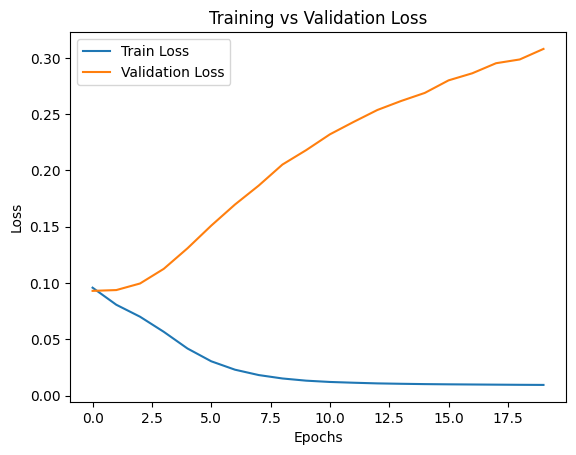

In [28]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [29]:
# Recreate the same architecture you trained
loaded_model = NextWord(
    block_size=block_size,
    vocab_size=len(stoi),
    emb_dim=emb_dim,
    hidden_size=hidden_size,
    activation=activation
).to(device)

loaded_model.load_state_dict(torch.load("emb_64_con_7_act_relu.pth", map_location=device))
loaded_model.eval()  # Set to evaluation mode
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [30]:
val_acc = 0

with torch.no_grad():
    preds = loaded_model(X_val)
    predicted = preds.argmax(dim=1)
    acc = (predicted == y_val).float().mean()
    val_acc = acc.item()
    print(f"Final Validation Accuracy: {acc.item()*100:.4f}%")
    print(f"Final Average Validation Loss: {avg_val_loss:.4f}")

Final Validation Accuracy: 9.7597%
Final Average Validation Loss: 0.3079


In [31]:
def predict_next(words, num_words=10, temperature=1.0):
    loaded_model.eval()
    context = [0] * block_size
    generated = []
    for w in words:
        context.append(stoi.get(w, stoi['<UNK>']))

    for step in range(num_words):
        x = torch.tensor(context[-block_size:]).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = loaded_model(x)
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

        next_idx = torch.multinomial(probs, num_samples=1).item()

        context.append(next_idx)
        generated.append(next_idx)

    ans = words + [itos[i] for i in generated]
    return ' '.join(ans)

In [32]:
print(predict_next(['sherlock', 'holmes'], num_words=20, temperature=0.01))

sherlock holmes sat moodily at one side of the so i wrote which it at the head of the coronet . a


In this experiment, the training loss decreases while the validation loss increases from the very first epoch. This suggests that the model begins to diverge early, likely due to a large vocabulary size, imbalance between training and validation data. This is a MLP based next word prediction problem and as we can see from the graph the top probabilities have very less difference between them thus there is a lot of chance that the sentence does not make any sense. For a better model we should try to increase no. of epoches or increase the dataset for better results.

The accuracy is around 10% which is not that good as there are alot of chance that we didn't want to say the greedy word and also the validation dataset will contain alot of very new sentences.

Done in local python file will run streamlit app

### 1.5 Comparative Analysis [1 mark]

• Compare your two trained models (Category I vs Category II):

	- Dataset size, vocabulary, context predictability
	- Model performance (loss curves, qualitative generations)
	- Embedding visualizations

• Summarize insights on how natural vs structured language differs in learnability.

In [33]:
file_2 = 'https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt'

all_text_2 = ""

response_2 = requests.get(file_2)
text_2 = response_2.text

all_text_2 += " " + text_2
print(all_text_2[:10000])

all_text_2 = all_text_2[0:2000000]

 /*
 * linux/kernel/irq/autoprobe.c
 *
 * Copyright (C) 1992, 1998-2004 Linus Torvalds, Ingo Molnar
 *
 * This file contains the interrupt probing code and driver APIs.
 */

#include <linux/irq.h>
#include <linux/module.h>
#include <linux/interrupt.h>
#include <linux/delay.h>
#include <linux/async.h>

#include "internals.h"

/*
 * Autodetection depends on the fact that any interrupt that
 * comes in on to an unassigned handler will get stuck with
 * "IRQS_WAITING" cleared and the interrupt disabled.
 */
static DEFINE_MUTEX(probing_active);

/**
 *	probe_irq_on	- begin an interrupt autodetect
 *
 *	Commence probing for an interrupt. The interrupts are scanned
 *	and a mask of potential interrupt lines is returned.
 *
 */
unsigned long probe_irq_on(void)
{
	struct irq_desc *desc;
	unsigned long mask = 0;
	int i;

	/*
	 * quiesce the kernel, or at least the asynchronous portion
	 */
	async_synchronize_full();
	mutex_lock(&probing_active);
	/*
	 * something may have generated an irq long a

In [34]:
words_2 = all_text_2.split()
word_counts_2 = Counter(words_2)

vocab_2 = list(word_counts_2.keys())
vocab_size_2 = len(vocab_2)

print("Vocabulary size (vocab_2):", vocab_size_2)

Vocabulary size (vocab_2): 43486


In [35]:
most_freq_2 = word_counts_2.most_common(10)
least_freq_2 = word_counts_2.most_common()[:-11:-1]

print("10 most frequent words (vocab_2):")
for word_2, freq_2 in most_freq_2:
    print(f"{word_2}: {freq_2}")
print()
print("10 least frequent words (vocab_2):")
for word_2, freq_2 in least_freq_2:
    print(f"{word_2}: {freq_2}")

10 most frequent words (vocab_2):
*: 11514
=: 8429
{: 5815
if: 5425
}: 5410
the: 5176
*/: 4635
/*: 4253
struct: 3637
return: 3127

10 least frequent words (vocab_2):
(WARN_ON(pwq->nr_in_flig: 1
drain_workqueue(wq);: 1
proceeding: 1
destroy_workqueue(struct: 1
Safely: 1
destroy_workqueue: 1
EXPORT_SYMBOL_GPL(__alloc_workqueue_key);: 1
destroy_workqueue(wq);: 1
err_destroy:: 1
err_free_wq:: 1


In [36]:
sentences_2 = all_text_2.split('\n')
sentences_2 = [s.strip() for s in sentences_2 if s.strip() != ""]
sentences_2 = [s.split() for s in sentences_2]

In [37]:
all_words_2 = []
for sentence_2 in sentences_2:
    for word_2 in sentence_2:
        all_words_2.append(word_2)

word_counts_2 = Counter(all_words_2)

vocab_2 = list(word_counts_2.keys())
vocab_size_2 = len(vocab_2)
print(vocab_size_2)

43486


In [38]:
stoi_2 = {}
itos_2 = {}

stoi_2['.'] = 0
itos_2[0] = '.'

for i, word_2 in enumerate(vocab_2):
    stoi_2[word_2] = i + 1
    itos_2[i + 1] = word_2

stoi_2['<UNK>'] = len(stoi_2)
itos_2[len(itos_2)] = '<UNK>'

In [39]:
X_2, y_2 = [], []

block_size_2 = 7

new_sentences_2 = []

for sentence_2 in sentences_2:
    sentence_2 = ['.'] * block_size_2 + sentence_2 + ['.']
    new_sentences_2.append(sentence_2)

for sentence_2 in new_sentences_2:
    for i in range(len(sentence_2) - block_size_2):
        temp_2 = []
        for j in range(block_size_2):
            word_2 = sentence_2[i + j]
            temp_2.append(stoi_2.get(word_2, stoi_2['<UNK>']))
        X_2.append(temp_2)
        target_word_2 = sentence_2[i + block_size_2]
        y_2.append(stoi_2.get(target_word_2, stoi_2['<UNK>']))

In [40]:
# Convert lists to tensors
X_tensor_2 = torch.tensor(X_2).to(device)
y_tensor_2 = torch.tensor(y_2).to(device)

# Split into train/validation sets
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_tensor_2, y_tensor_2, test_size=0.1, random_state=42)

In [41]:
train_data_2 = TensorDataset(X_train_2, y_train_2)
val_data_2 = TensorDataset(X_val_2, y_val_2)

train_loader_2 = DataLoader(train_data_2, batch_size=64, shuffle=True)
val_loader_2 = DataLoader(val_data_2, batch_size=64)

In [42]:
# Model setup
vocab_size_2 = len(stoi_2)
emb_dim_2 = 64
hidden_size_2 = 1024
activation_2 = 'relu'

model_2 = NextWord(block_size_2, vocab_size_2, emb_dim_2, hidden_size_2, activation_2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

epochs = 20

train_losses_2, val_losses_2 = [], []

for epoch in range(epochs):
    model_2.train()
    total_train_loss_2 = 0
    for X_batch, y_batch in train_loader_2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_2(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss_2 += loss.item()

    avg_train_loss_2 = total_train_loss_2 / len(y_train)
    train_losses_2.append(avg_train_loss_2)

    model_2.eval()
    total_val_loss_2 = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_2:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model_2(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss_2 += val_loss.item()

    avg_val_loss_2 = total_val_loss_2 / len(y_val)
    val_losses_2.append(avg_val_loss_2)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss_2:.4f} | Val Loss: {avg_val_loss_2:.4f}")

Epoch 1/20 | Train Loss: 0.2573 | Val Loss: 0.2494
Epoch 2/20 | Train Loss: 0.2143 | Val Loss: 0.2500
Epoch 3/20 | Train Loss: 0.1896 | Val Loss: 0.2639
Epoch 4/20 | Train Loss: 0.1694 | Val Loss: 0.2780
Epoch 5/20 | Train Loss: 0.1522 | Val Loss: 0.2969
Epoch 6/20 | Train Loss: 0.1379 | Val Loss: 0.3167
Epoch 7/20 | Train Loss: 0.1260 | Val Loss: 0.3320
Epoch 8/20 | Train Loss: 0.1164 | Val Loss: 0.3536
Epoch 9/20 | Train Loss: 0.1091 | Val Loss: 0.3743
Epoch 10/20 | Train Loss: 0.1034 | Val Loss: 0.3976
Epoch 11/20 | Train Loss: 0.0990 | Val Loss: 0.4115
Epoch 12/20 | Train Loss: 0.0957 | Val Loss: 0.4310
Epoch 13/20 | Train Loss: 0.0931 | Val Loss: 0.4505
Epoch 14/20 | Train Loss: 0.0911 | Val Loss: 0.4617
Epoch 15/20 | Train Loss: 0.0895 | Val Loss: 0.4810
Epoch 16/20 | Train Loss: 0.0883 | Val Loss: 0.4939
Epoch 17/20 | Train Loss: 0.0873 | Val Loss: 0.5049
Epoch 18/20 | Train Loss: 0.0864 | Val Loss: 0.5219
Epoch 19/20 | Train Loss: 0.0858 | Val Loss: 0.5249
Epoch 20/20 | Train L

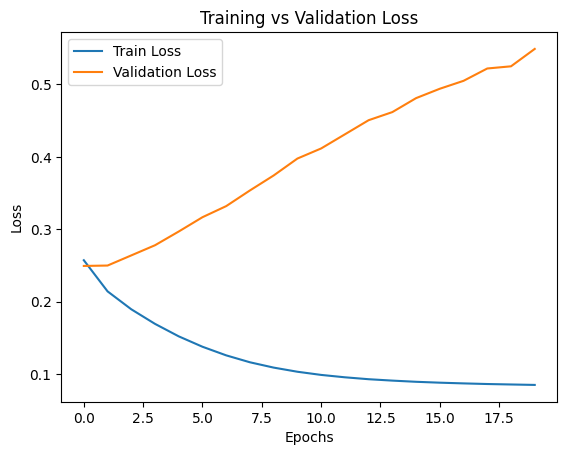

In [43]:
plt.plot(train_losses_2, label='Train Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [44]:
val_acc_2 = 0

with torch.no_grad():
    preds = model_2(X_val_2)
    predicted = preds.argmax(dim=1)
    acc = (predicted == y_val_2).float().mean()
    val_acc_2 = acc.item()

In [49]:
dataset_size = len(all_text)
dataset_size_2 = len(all_text_2)

print(f"| Metric                 | Category 1 | Category 2 |")
print(f"|------------------------|------------|------------|")
print(f"| Dataset Size           | {dataset_size}     | {dataset_size_2}    |")
print(f"| Vocabulary Size        | {vocab_size}       | {vocab_size_2}      |")
print(f"| Average Training Loss  | {avg_train_loss:.2f}       | {avg_train_loss_2:.2f}       |")
print(f"| Average Validation Loss| {avg_val_loss:.2f}       | {avg_val_loss_2:.2f}       |")
print(f"| Validation Accuracy    | {val_acc:.2f}       | {val_acc_2:.2f}       |")

| Metric                 | Category 1 | Category 2 |
|------------------------|------------|------------|
| Dataset Size           | 564373     | 2000000    |
| Vocabulary Size        | 8685       | 43487      |
| Average Training Loss  | 0.01       | 0.09       |
| Average Validation Loss| 0.31       | 0.55       |
| Validation Accuracy    | 0.10       | 0.33       |


In [46]:
def predict_next_2(words, num_words=10, temperature=1.0):
    model_2.eval()
    context = [0] * block_size_2
    generated = []
    for w in words:
        context.append(stoi_2.get(w, stoi_2['<UNK>']))

    for step in range(num_words):
        x = torch.tensor(context[-block_size_2:]).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model_2(x)
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

        next_idx = torch.multinomial(probs, num_samples=1).item()

        context.append(next_idx)
        generated.append(next_idx)

    ans = words + [itos_2[i] for i in generated]
    return ' '.join(ans)

In [47]:
print(predict_next_2(['unsigned','long'], num_words=30, temperature=0.1))

unsigned long offline, . . . duration . smt_power . udd->tu->offset; . oprofile . . . . . * . Ensures that if SIGCONT 0 is . cpu . "%s > excessive


The vocabulary size of natural language should be more but in this case the vocab size of structed is more as a lot of things are written without space and it results in large vocab size due to not a good tokenizer. The structed language has a lot repetetion of new line and different symbols. It is easier to learn structed language as there is a lot repetition.

### 1.3 Embedding Visualization and Interpretation [1 mark]

Visualize the embeddings using t-SNE if using more than 2 dimensions or using a scatter plot if using 2 dimensions and write your observations. For visualizations, you may have to select words with relations like synonyms, antonyms, names and pronouns, verbs and adverbs, words with no relations, and so on. Discuss your observations on clustering patterns and semantic relationships.


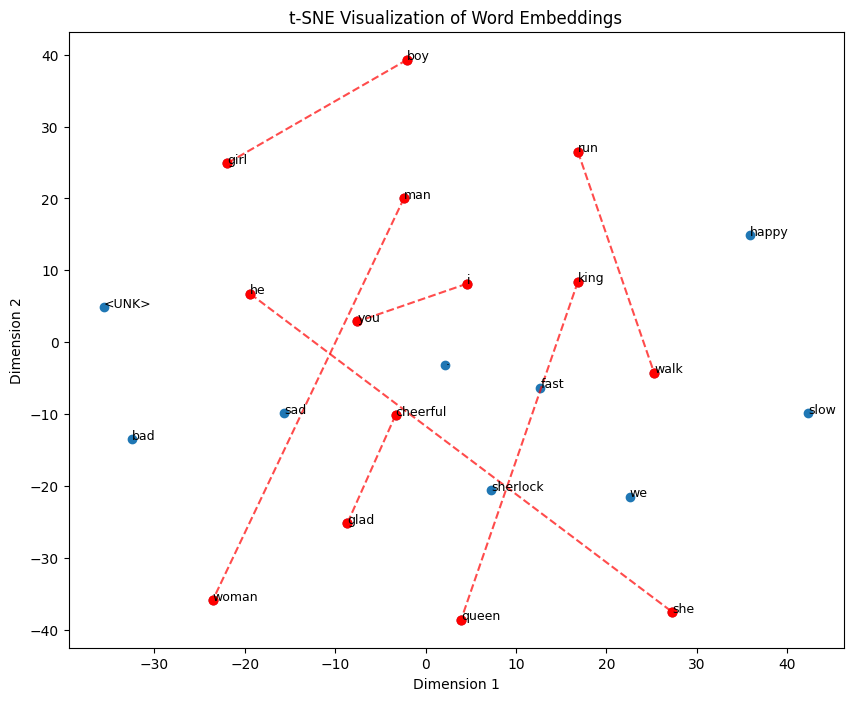

In [ ]:
# Extract embeddings
embeddings = loaded_model.emb.weight.detach().cpu().numpy()

# Choose words to visualize
selected_words = [
    "king", "queen", "man", "woman", "boy", "girl",  # same relation
    "happy", "glad", "cheerful", "sad", "unhappy" # synonyms
    "good", "bad", "fast", "slow",  # antonyms
    "run", "walk", # verbs
    "i", "you", "he", "she", "we", # pronouns
    "sherlock", "holmes" # names
    "apple", "banana", ".", "<UNK>" # no relation
]

# Pairs to connect with lines
related_pairs = [
    ("king", "queen"),
    ("man", "woman"),
    ("boy", "girl"),
    ("run", "walk"),
    ("i","you"),
    ("he","she"),
    ("cheerful","glad")
]

selected_idx = [stoi[w] for w in selected_words if w in stoi]
selected_labels = [w for w in selected_words if w in stoi]

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(embeddings[selected_idx])

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i, label in enumerate(selected_labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

label_to_idx = {label: idx for idx, label in enumerate(selected_labels)}

for w1, w2 in related_pairs:
    if w1 in label_to_idx and w2 in label_to_idx:
        i1, i2 = label_to_idx[w1], label_to_idx[w2]
        x1, y1 = embeddings_2d[i1]
        x2, y2 = embeddings_2d[i2]
        plt.plot([x1, x2], [y1, y2], color="red", linestyle="--", alpha=0.7)
        plt.scatter([x1, x2], [y1, y2], color="red", s=40)

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

13


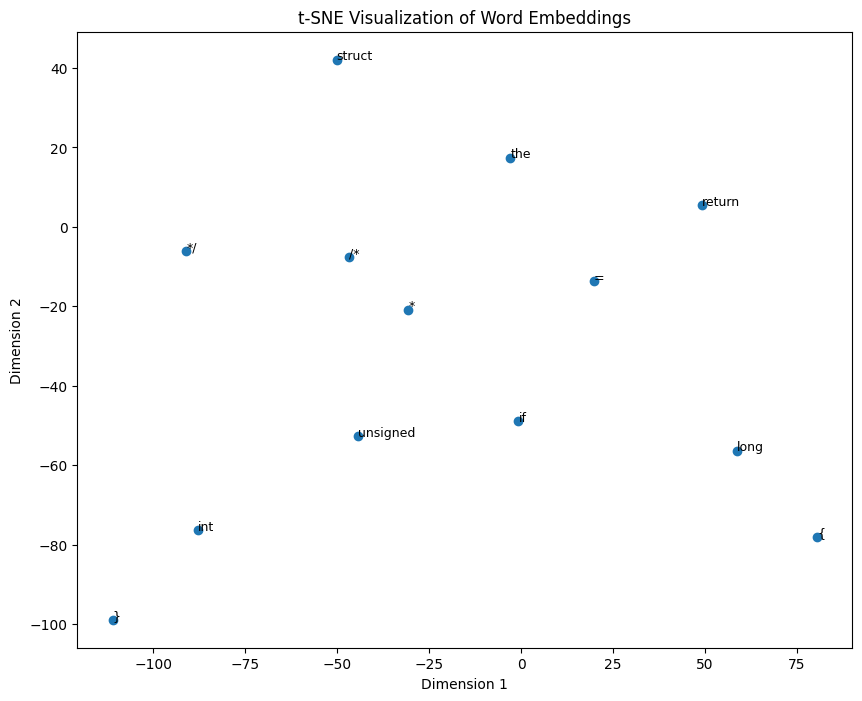

In [48]:
# Extract embeddings
embeddings = model_2.emb.weight.detach().cpu().numpy()

# Choose words to visualize
selected_words = [
    "int",
    "long",
    "unsigned",
    "*",
    "=",
    "{",
    "if",
    "}",
    "the",
    "*/",
    "/*",
    "struct",
    "return"
]

selected_idx = [stoi_2[w] for w in selected_words if w in stoi_2]
selected_labels = [w for w in selected_words if w in stoi_2]
print(len(selected_idx))


tsne = TSNE(n_components=2, random_state=42, perplexity=2)
embeddings_2d = tsne.fit_transform(embeddings[selected_idx])

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i, label in enumerate(selected_labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### 1.4 Streamlit Application [1.5 marks]
Write a streamlit application that asks users for an input text, and it then predicts the next k words or lines. In the streamlit app, you should have controls for modifying context length, embedding dimension, activation function, random seed, etc. You can use any one of the datasets mentioned. Incorporate temperature control in your streamlit app to control the randomness of predicted words. Refer to this article.

### Training other models for streamlit app

In [ ]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 32
hidden_size = 1024
activation = 'relu'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_32_con_7_act_relu.pth")

Epoch 1/20 | Train Loss: 0.0961 | Val Loss: 0.0928
Epoch 2/20 | Train Loss: 0.0804 | Val Loss: 0.0930
Epoch 3/20 | Train Loss: 0.0689 | Val Loss: 0.0990
Epoch 4/20 | Train Loss: 0.0541 | Val Loss: 0.1140
Epoch 5/20 | Train Loss: 0.0404 | Val Loss: 0.1305
Epoch 6/20 | Train Loss: 0.0315 | Val Loss: 0.1466
Epoch 7/20 | Train Loss: 0.0256 | Val Loss: 0.1635
Epoch 8/20 | Train Loss: 0.0215 | Val Loss: 0.1783
Epoch 9/20 | Train Loss: 0.0184 | Val Loss: 0.1915
Epoch 10/20 | Train Loss: 0.0161 | Val Loss: 0.2064
Epoch 11/20 | Train Loss: 0.0144 | Val Loss: 0.2192
Epoch 12/20 | Train Loss: 0.0131 | Val Loss: 0.2339
Epoch 13/20 | Train Loss: 0.0121 | Val Loss: 0.2427
Epoch 14/20 | Train Loss: 0.0115 | Val Loss: 0.2526
Epoch 15/20 | Train Loss: 0.0110 | Val Loss: 0.2633
Epoch 16/20 | Train Loss: 0.0107 | Val Loss: 0.2722
Epoch 17/20 | Train Loss: 0.0103 | Val Loss: 0.2807
Epoch 18/20 | Train Loss: 0.0102 | Val Loss: 0.2892
Epoch 19/20 | Train Loss: 0.0100 | Val Loss: 0.2958
Epoch 20/20 | Train L

In [ ]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 64
hidden_size = 1024
activation = 'tanh'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_64_con_7_act_tanh.pth")

Epoch 1/20 | Train Loss: 0.0983 | Val Loss: 0.0944
Epoch 2/20 | Train Loss: 0.0687 | Val Loss: 0.0984
Epoch 3/20 | Train Loss: 0.0512 | Val Loss: 0.1055
Epoch 4/20 | Train Loss: 0.0433 | Val Loss: 0.1119
Epoch 5/20 | Train Loss: 0.0379 | Val Loss: 0.1177
Epoch 6/20 | Train Loss: 0.0332 | Val Loss: 0.1232
Epoch 7/20 | Train Loss: 0.0289 | Val Loss: 0.1283
Epoch 8/20 | Train Loss: 0.0251 | Val Loss: 0.1333
Epoch 9/20 | Train Loss: 0.0216 | Val Loss: 0.1388
Epoch 10/20 | Train Loss: 0.0190 | Val Loss: 0.1433
Epoch 11/20 | Train Loss: 0.0172 | Val Loss: 0.1485
Epoch 12/20 | Train Loss: 0.0161 | Val Loss: 0.1526
Epoch 13/20 | Train Loss: 0.0156 | Val Loss: 0.1556
Epoch 14/20 | Train Loss: 0.0153 | Val Loss: 0.1594
Epoch 15/20 | Train Loss: 0.0150 | Val Loss: 0.1615
Epoch 16/20 | Train Loss: 0.0149 | Val Loss: 0.1648
Epoch 17/20 | Train Loss: 0.0148 | Val Loss: 0.1667
Epoch 18/20 | Train Loss: 0.0146 | Val Loss: 0.1676
Epoch 19/20 | Train Loss: 0.0146 | Val Loss: 0.1695
Epoch 20/20 | Train L

In [ ]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 32
hidden_size = 1024
activation = 'tanh'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_32_con_7_act_tanh.pth")

Epoch 1/20 | Train Loss: 0.0984 | Val Loss: 0.0951
Epoch 2/20 | Train Loss: 0.0730 | Val Loss: 0.0986
Epoch 3/20 | Train Loss: 0.0582 | Val Loss: 0.1055
Epoch 4/20 | Train Loss: 0.0519 | Val Loss: 0.1113
Epoch 5/20 | Train Loss: 0.0475 | Val Loss: 0.1159
Epoch 6/20 | Train Loss: 0.0437 | Val Loss: 0.1215
Epoch 7/20 | Train Loss: 0.0402 | Val Loss: 0.1249
Epoch 8/20 | Train Loss: 0.0367 | Val Loss: 0.1288
Epoch 9/20 | Train Loss: 0.0334 | Val Loss: 0.1332
Epoch 10/20 | Train Loss: 0.0303 | Val Loss: 0.1375
Epoch 11/20 | Train Loss: 0.0274 | Val Loss: 0.1410
Epoch 12/20 | Train Loss: 0.0246 | Val Loss: 0.1453
Epoch 13/20 | Train Loss: 0.0223 | Val Loss: 0.1492
Epoch 14/20 | Train Loss: 0.0204 | Val Loss: 0.1534
Epoch 15/20 | Train Loss: 0.0188 | Val Loss: 0.1569
Epoch 16/20 | Train Loss: 0.0175 | Val Loss: 0.1611
Epoch 17/20 | Train Loss: 0.0166 | Val Loss: 0.1637
Epoch 18/20 | Train Loss: 0.0159 | Val Loss: 0.1673
Epoch 19/20 | Train Loss: 0.0154 | Val Loss: 0.1713
Epoch 20/20 | Train L

In [ ]:
X, y = [], []

block_size = 5

new_sentences = []

for sentence in sentences:
    sentence = ['.']*block_size + sentence + ['.']
    new_sentences.append(sentence)

for sentence in new_sentences:
    for i in range(len(sentence) - block_size):
        temp = []
        for j in range(block_size):
            word = sentence[i + j]
            temp.append(stoi.get(word, stoi['<UNK>']))
        X.append(temp)
        target_word = sentence[i + block_size]
        y.append(stoi.get(target_word, stoi['<UNK>']))

In [ ]:
# Convert lists to tensors
X_tensor = torch.tensor(X).to(device)
y_tensor = torch.tensor(y).to(device)

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

In [ ]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

In [ ]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 32
hidden_size = 1024
activation = 'tanh'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_32_con_5_act_tanh.pth")

Epoch 1/20 | Train Loss: 0.0975 | Val Loss: 0.0937
Epoch 2/20 | Train Loss: 0.0747 | Val Loss: 0.0974
Epoch 3/20 | Train Loss: 0.0621 | Val Loss: 0.1044
Epoch 4/20 | Train Loss: 0.0561 | Val Loss: 0.1105
Epoch 5/20 | Train Loss: 0.0522 | Val Loss: 0.1148
Epoch 6/20 | Train Loss: 0.0486 | Val Loss: 0.1199
Epoch 7/20 | Train Loss: 0.0453 | Val Loss: 0.1239
Epoch 8/20 | Train Loss: 0.0421 | Val Loss: 0.1283
Epoch 9/20 | Train Loss: 0.0389 | Val Loss: 0.1321
Epoch 10/20 | Train Loss: 0.0359 | Val Loss: 0.1352
Epoch 11/20 | Train Loss: 0.0330 | Val Loss: 0.1386
Epoch 12/20 | Train Loss: 0.0303 | Val Loss: 0.1424
Epoch 13/20 | Train Loss: 0.0279 | Val Loss: 0.1454
Epoch 14/20 | Train Loss: 0.0256 | Val Loss: 0.1490
Epoch 15/20 | Train Loss: 0.0236 | Val Loss: 0.1524
Epoch 16/20 | Train Loss: 0.0219 | Val Loss: 0.1565
Epoch 17/20 | Train Loss: 0.0205 | Val Loss: 0.1593
Epoch 18/20 | Train Loss: 0.0193 | Val Loss: 0.1635
Epoch 19/20 | Train Loss: 0.0183 | Val Loss: 0.1660
Epoch 20/20 | Train L

In [ ]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 64
hidden_size = 1024
activation = 'tanh'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_64_con_5_act_tanh.pth")

Epoch 1/20 | Train Loss: 0.0971 | Val Loss: 0.0936
Epoch 2/20 | Train Loss: 0.0706 | Val Loss: 0.0979
Epoch 3/20 | Train Loss: 0.0550 | Val Loss: 0.1052
Epoch 4/20 | Train Loss: 0.0478 | Val Loss: 0.1113
Epoch 5/20 | Train Loss: 0.0427 | Val Loss: 0.1171
Epoch 6/20 | Train Loss: 0.0384 | Val Loss: 0.1216
Epoch 7/20 | Train Loss: 0.0344 | Val Loss: 0.1269
Epoch 8/20 | Train Loss: 0.0308 | Val Loss: 0.1316
Epoch 9/20 | Train Loss: 0.0274 | Val Loss: 0.1361
Epoch 10/20 | Train Loss: 0.0242 | Val Loss: 0.1404
Epoch 11/20 | Train Loss: 0.0216 | Val Loss: 0.1453
Epoch 12/20 | Train Loss: 0.0194 | Val Loss: 0.1489
Epoch 13/20 | Train Loss: 0.0180 | Val Loss: 0.1534
Epoch 14/20 | Train Loss: 0.0171 | Val Loss: 0.1573
Epoch 15/20 | Train Loss: 0.0165 | Val Loss: 0.1605
Epoch 16/20 | Train Loss: 0.0163 | Val Loss: 0.1631
Epoch 17/20 | Train Loss: 0.0160 | Val Loss: 0.1661
Epoch 18/20 | Train Loss: 0.0159 | Val Loss: 0.1678
Epoch 19/20 | Train Loss: 0.0158 | Val Loss: 0.1709
Epoch 20/20 | Train L

In [ ]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 32
hidden_size = 1024
activation = 'relu'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_32_con_5_act_relu.pth")

Epoch 1/20 | Train Loss: 0.0951 | Val Loss: 0.0914
Epoch 2/20 | Train Loss: 0.0785 | Val Loss: 0.0921
Epoch 3/20 | Train Loss: 0.0658 | Val Loss: 0.0999
Epoch 4/20 | Train Loss: 0.0504 | Val Loss: 0.1143
Epoch 5/20 | Train Loss: 0.0387 | Val Loss: 0.1302
Epoch 6/20 | Train Loss: 0.0317 | Val Loss: 0.1448
Epoch 7/20 | Train Loss: 0.0270 | Val Loss: 0.1586
Epoch 8/20 | Train Loss: 0.0235 | Val Loss: 0.1699
Epoch 9/20 | Train Loss: 0.0207 | Val Loss: 0.1826
Epoch 10/20 | Train Loss: 0.0185 | Val Loss: 0.1936
Epoch 11/20 | Train Loss: 0.0168 | Val Loss: 0.2061
Epoch 12/20 | Train Loss: 0.0152 | Val Loss: 0.2169
Epoch 13/20 | Train Loss: 0.0140 | Val Loss: 0.2276
Epoch 14/20 | Train Loss: 0.0131 | Val Loss: 0.2378
Epoch 15/20 | Train Loss: 0.0123 | Val Loss: 0.2489
Epoch 16/20 | Train Loss: 0.0118 | Val Loss: 0.2571
Epoch 17/20 | Train Loss: 0.0114 | Val Loss: 0.2651
Epoch 18/20 | Train Loss: 0.0110 | Val Loss: 0.2737
Epoch 19/20 | Train Loss: 0.0108 | Val Loss: 0.2817
Epoch 20/20 | Train L

In [ ]:
# Change setting from here
vocab_size = len(stoi)
emb_dim = 64
hidden_size = 1024
activation = 'relu'

model = NextWord(block_size, vocab_size, emb_dim, hidden_size, activation).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(y_train)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(y_val)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "emb_64_con_5_act_relu.pth")

Epoch 1/20 | Train Loss: 0.0948 | Val Loss: 0.0913
Epoch 2/20 | Train Loss: 0.0783 | Val Loss: 0.0919
Epoch 3/20 | Train Loss: 0.0664 | Val Loss: 0.0989
Epoch 4/20 | Train Loss: 0.0520 | Val Loss: 0.1127
Epoch 5/20 | Train Loss: 0.0382 | Val Loss: 0.1317
Epoch 6/20 | Train Loss: 0.0287 | Val Loss: 0.1508
Epoch 7/20 | Train Loss: 0.0225 | Val Loss: 0.1664
Epoch 8/20 | Train Loss: 0.0183 | Val Loss: 0.1831
Epoch 9/20 | Train Loss: 0.0156 | Val Loss: 0.1988
Epoch 10/20 | Train Loss: 0.0137 | Val Loss: 0.2126
Epoch 11/20 | Train Loss: 0.0125 | Val Loss: 0.2253
Epoch 12/20 | Train Loss: 0.0116 | Val Loss: 0.2352
Epoch 13/20 | Train Loss: 0.0112 | Val Loss: 0.2458
Epoch 14/20 | Train Loss: 0.0108 | Val Loss: 0.2547
Epoch 15/20 | Train Loss: 0.0106 | Val Loss: 0.2619
Epoch 16/20 | Train Loss: 0.0104 | Val Loss: 0.2662
Epoch 17/20 | Train Loss: 0.0102 | Val Loss: 0.2765
Epoch 18/20 | Train Loss: 0.0100 | Val Loss: 0.2813
Epoch 19/20 | Train Loss: 0.0100 | Val Loss: 0.2908
Epoch 20/20 | Train L